In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('filtered_booking.csv', index_col=0)

In [4]:
df = df.reset_index(drop=True)

In [5]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49978,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49979,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49980,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [6]:
df_final = df

In [7]:
from sklearn.preprocessing import OneHotEncoder


#create instance of one hot encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#one hot encode Sales Channel
encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'Internet', 1:'Mobile'})
df_final = df_final.join(encoder_df)

#one hot encode trip type
encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'RoundTRip', 1:'OneWayTrip',2:'CircleTrip'})
df_final = df_final.join(encoder_df)

In [8]:
#drop categorical columns now
df_final.drop(['sales_channel', 'trip_type','booking_origin', 'route'], axis=1, inplace = True)

In [9]:
#store the label for supervised learning
label = df['booking_complete']

In [10]:
df_final = df_final.drop('booking_complete', axis=1)

### Normalizing the values

In [12]:
from sklearn.preprocessing import StandardScaler

#create a standard scaler object
scaler = StandardScaler()

#fit and transform the data
scaled_df = scaler.fit_transform(df_final)

In [13]:
#create a dataframe of scled data
scaled_df = pd.DataFrame(scaled_df, columns = df_final.columns)

In [14]:
# add the labels back to the dataframe
scaled_df['label']  = label

### Correlation matrix

<Axes: >

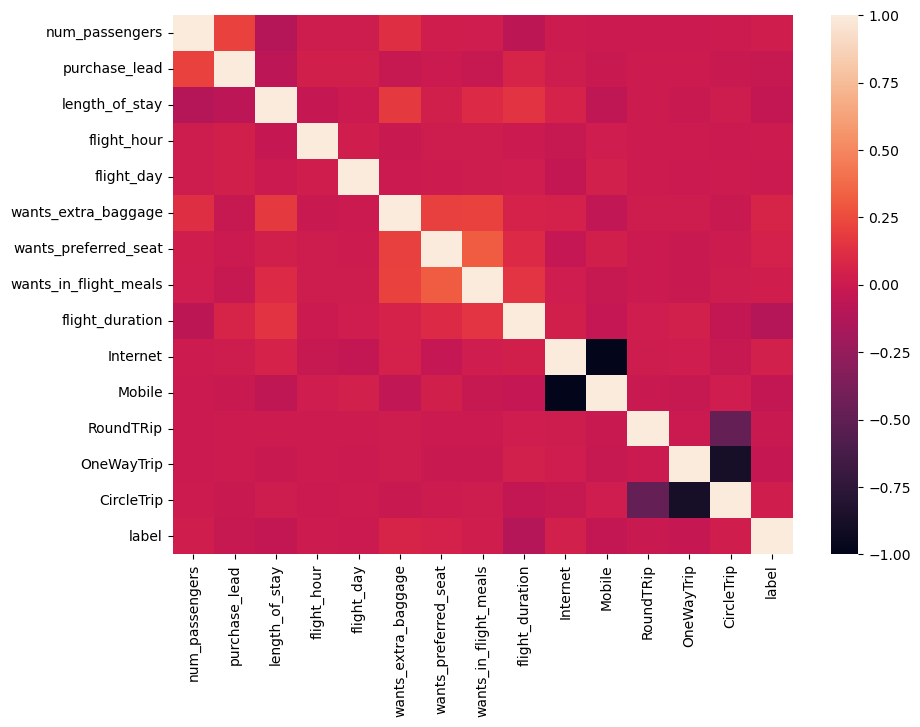

In [16]:
corr = scaled_df.corr()

plt.figure(figsize=(10,7))

#plot the heatmap
sns.heatmap(corr)

### Splitting into train and test data

In [18]:
from sklearn.model_selection import train_test_split

X = scaled_df.iloc[:,:-1]
y = scaled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV,  RepeatedStratifiedKFold

In [21]:
"""
    Create functions to fit and predict the values of whether customer would complete the booking.
    Also functions with metrics to evaluate the model prediction.

"""

def model_fit_predict(model, X, y, X_predict):
    model.fit(X, y)
    return model.predict(X_predict)

def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def pre_score(y_true, y_pred):
    return precision_score(y_true, y_pred)

def f_score(y_true, y_pred):
    return f1_score(y_true, y_pred)

### Random forest classifier

In [23]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
set(y_pred_train)

#f1 score for training data
f1 = round(f1_score(y_train, y_pred_train),2) 

#accuracy score for training data
acc = round(accuracy_score(y_train, y_pred_train),2) 

#precision score for training data
pre = round(precision_score(y_train, y_pred_train),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.93, 1.0 and 0.72 respectively


0.9341002876078529

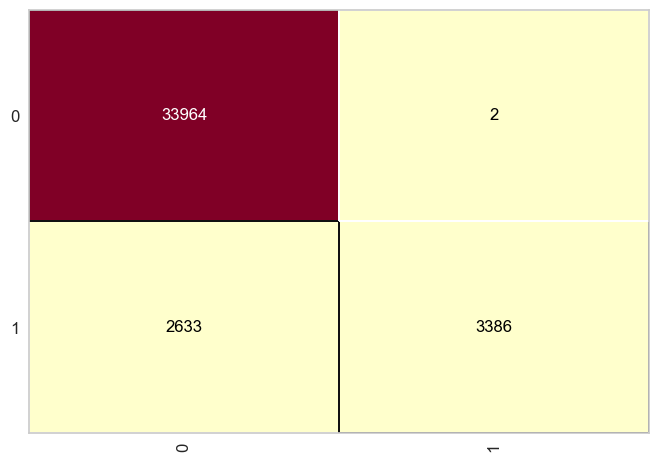

In [26]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_train, y_train)

### Checking testing accuracy

In [28]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.86, 0.56 and 0.07 respectively


0.8554566369910973

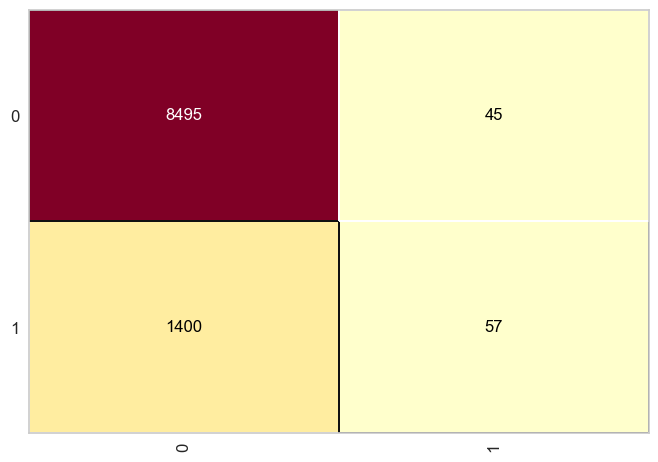

In [29]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

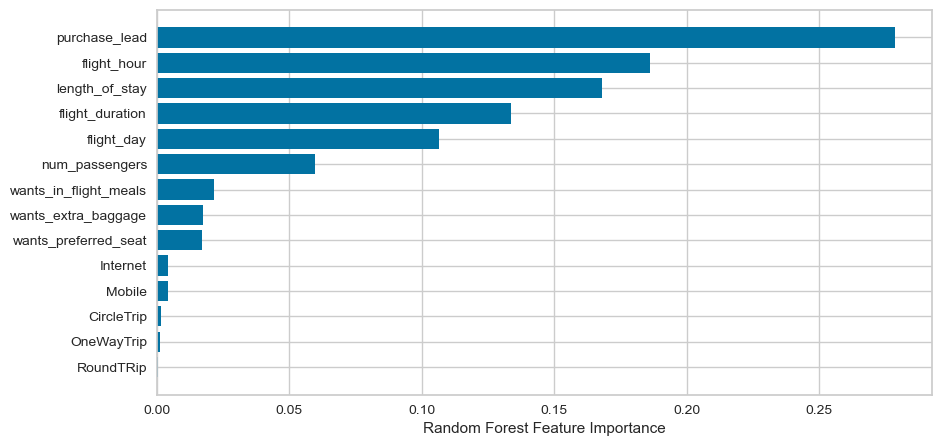

In [30]:
plt.figure(figsize=(10,5))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Balancing the dataset

In [32]:
scaled_df.label.value_counts()

label
0    42506
1     7476
Name: count, dtype: int64

In [33]:
#create a dataframe having all labels 0 with 10000 samples
scaled_df_0 = scaled_df[scaled_df.label ==0].sample(n=8000)

In [34]:
#concatenate the two dataframee, one havng all labels 0 and other having all labels as 1
scaled_df_new = pd.concat([scaled_df[scaled_df.label==1], scaled_df_0], ignore_index=True)

In [35]:
#shuffle the dataframe rows
scaled_df_new = scaled_df_new.sample(frac = 1).reset_index(drop=True)

In [36]:
X = scaled_df_new.iloc[:,:-1]
y = scaled_df_new['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [37]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(n_estimators=50,max_depth =50 , min_samples_split=5,random_state=0)

In [38]:
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

recall = round(recall_score(y_test, y_pred_test),2)

specificity = round(recall_score(y_test, y_pred_test, pos_label=0),2)

print(f"Accuracy, precision, recall and f1-score for training data are {acc}, {pre}, {recall}, {specificity} and {f1} respectively")

Accuracy, precision, recall and f1-score for training data are 0.61, 0.59, 0.58, 0.64 and 0.58 respectively


0.6120801033591732

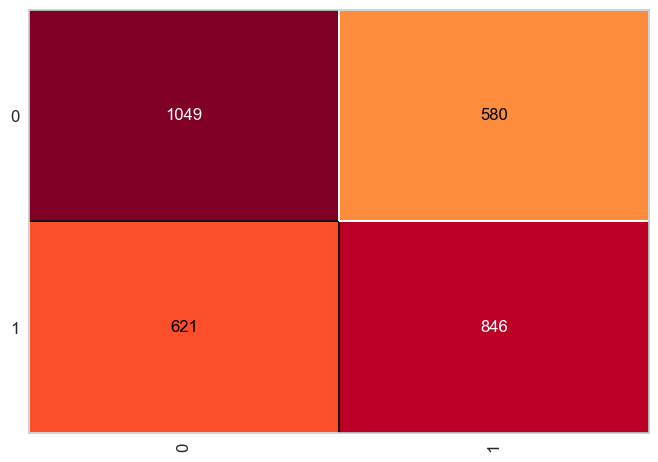

In [39]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

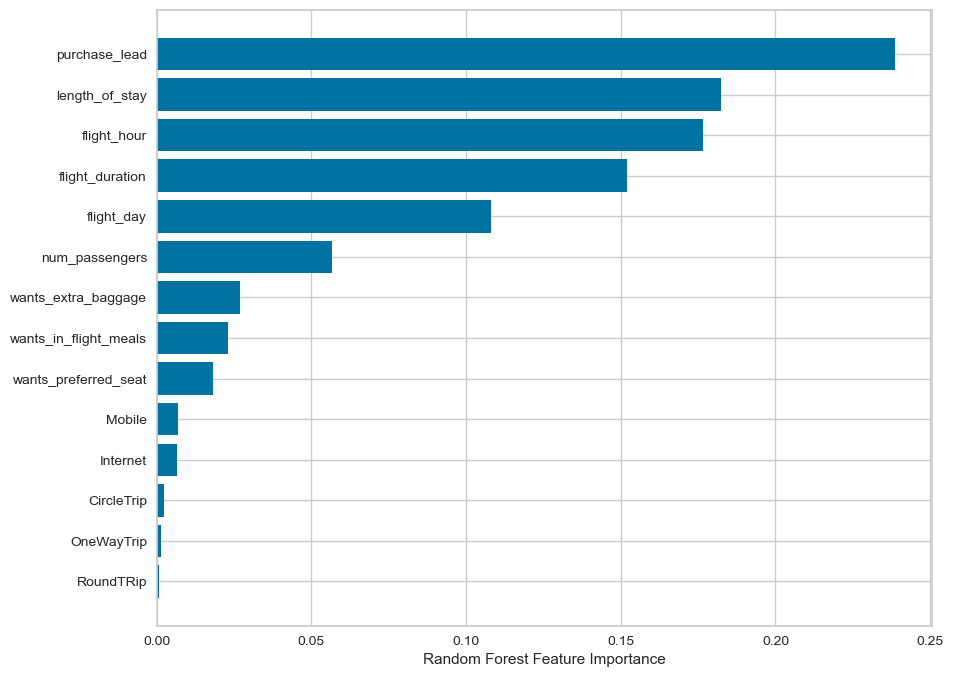

In [40]:
plt.figure(figsize=(10,8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")